# Data Science Task

The electrocardiogram (ECG) is a non-invasive representation of the electrical activity of the heart from electrodes placed on the surface of the torso. The standard 12-lead ECG has been widely used to diagnose a variety of cardiac abnormalities such as cardiac arrhythmias, and predicts cardiovascular morbidity and mortality. The early and correct diagnosis of cardiac abnormalities can increase the chances of successful treatments. However, manual interpretation of the electrocardiogram is time-consuming, and requires skilled personnel with a high degree of training.

Automatic detection and classification of cardiac abnormalities can assist physicians in the diagnosis of the growing number of ECGs recorded. Over the last decade, there have been increasing numbers of attempts to stimulate 12-lead ECG classification. Many of these algorithms seem to have the potential for accurate identification of cardiac abnormalities. However, most of these methods have only been tested or developed in single, small, or relatively homogeneous datasets.

### Tasks 

* Be able to read the ECG files and corresponding annotations
* Show how they will work on the signal and plot the signal in appropriate manner to be read by a doctor
* Identify the heart beat of the signal, average and total heart beat in the signal
* Identify the complex QRS in the signal and been able to annotate on it

### Import the Object-Oriented Libraries

We have imported the necessary libraries for the project

In [2]:
import pandas as pd
import numpy as np
import os

import seaborn as sns
import matplotlib.pyplot as plt

import wget
import wfdb
import ast

### Load the data

In [3]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [4]:
path = '/Users/adriana/Documents/GitHub/data/physionet.org/files/ptb-xl/1.0.2/'
sampling_rate=100

# load and convert annotation data
metadata_frame = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
metadata_frame.scp_codes = metadata_frame.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
raw_ecg = load_raw_data(metadata_frame, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

# Apply diagnostic superclass
metadata_frame['diagnostic_superclass'] = metadata_frame.scp_codes.apply(aggregate_diagnostic)

#?
metadata_frame['diagnostic_superclass'] = metadata_frame['diagnostic_superclass'].astype(str)

### Visualization of Raw ECG Data

First, I plotted the raw ECG data for a randomly selected patient from the dataset. I visualized the raw ECG signals for each of the 12 leads. Each lead captures a different signal based on the orientation of the electrodes on the body.

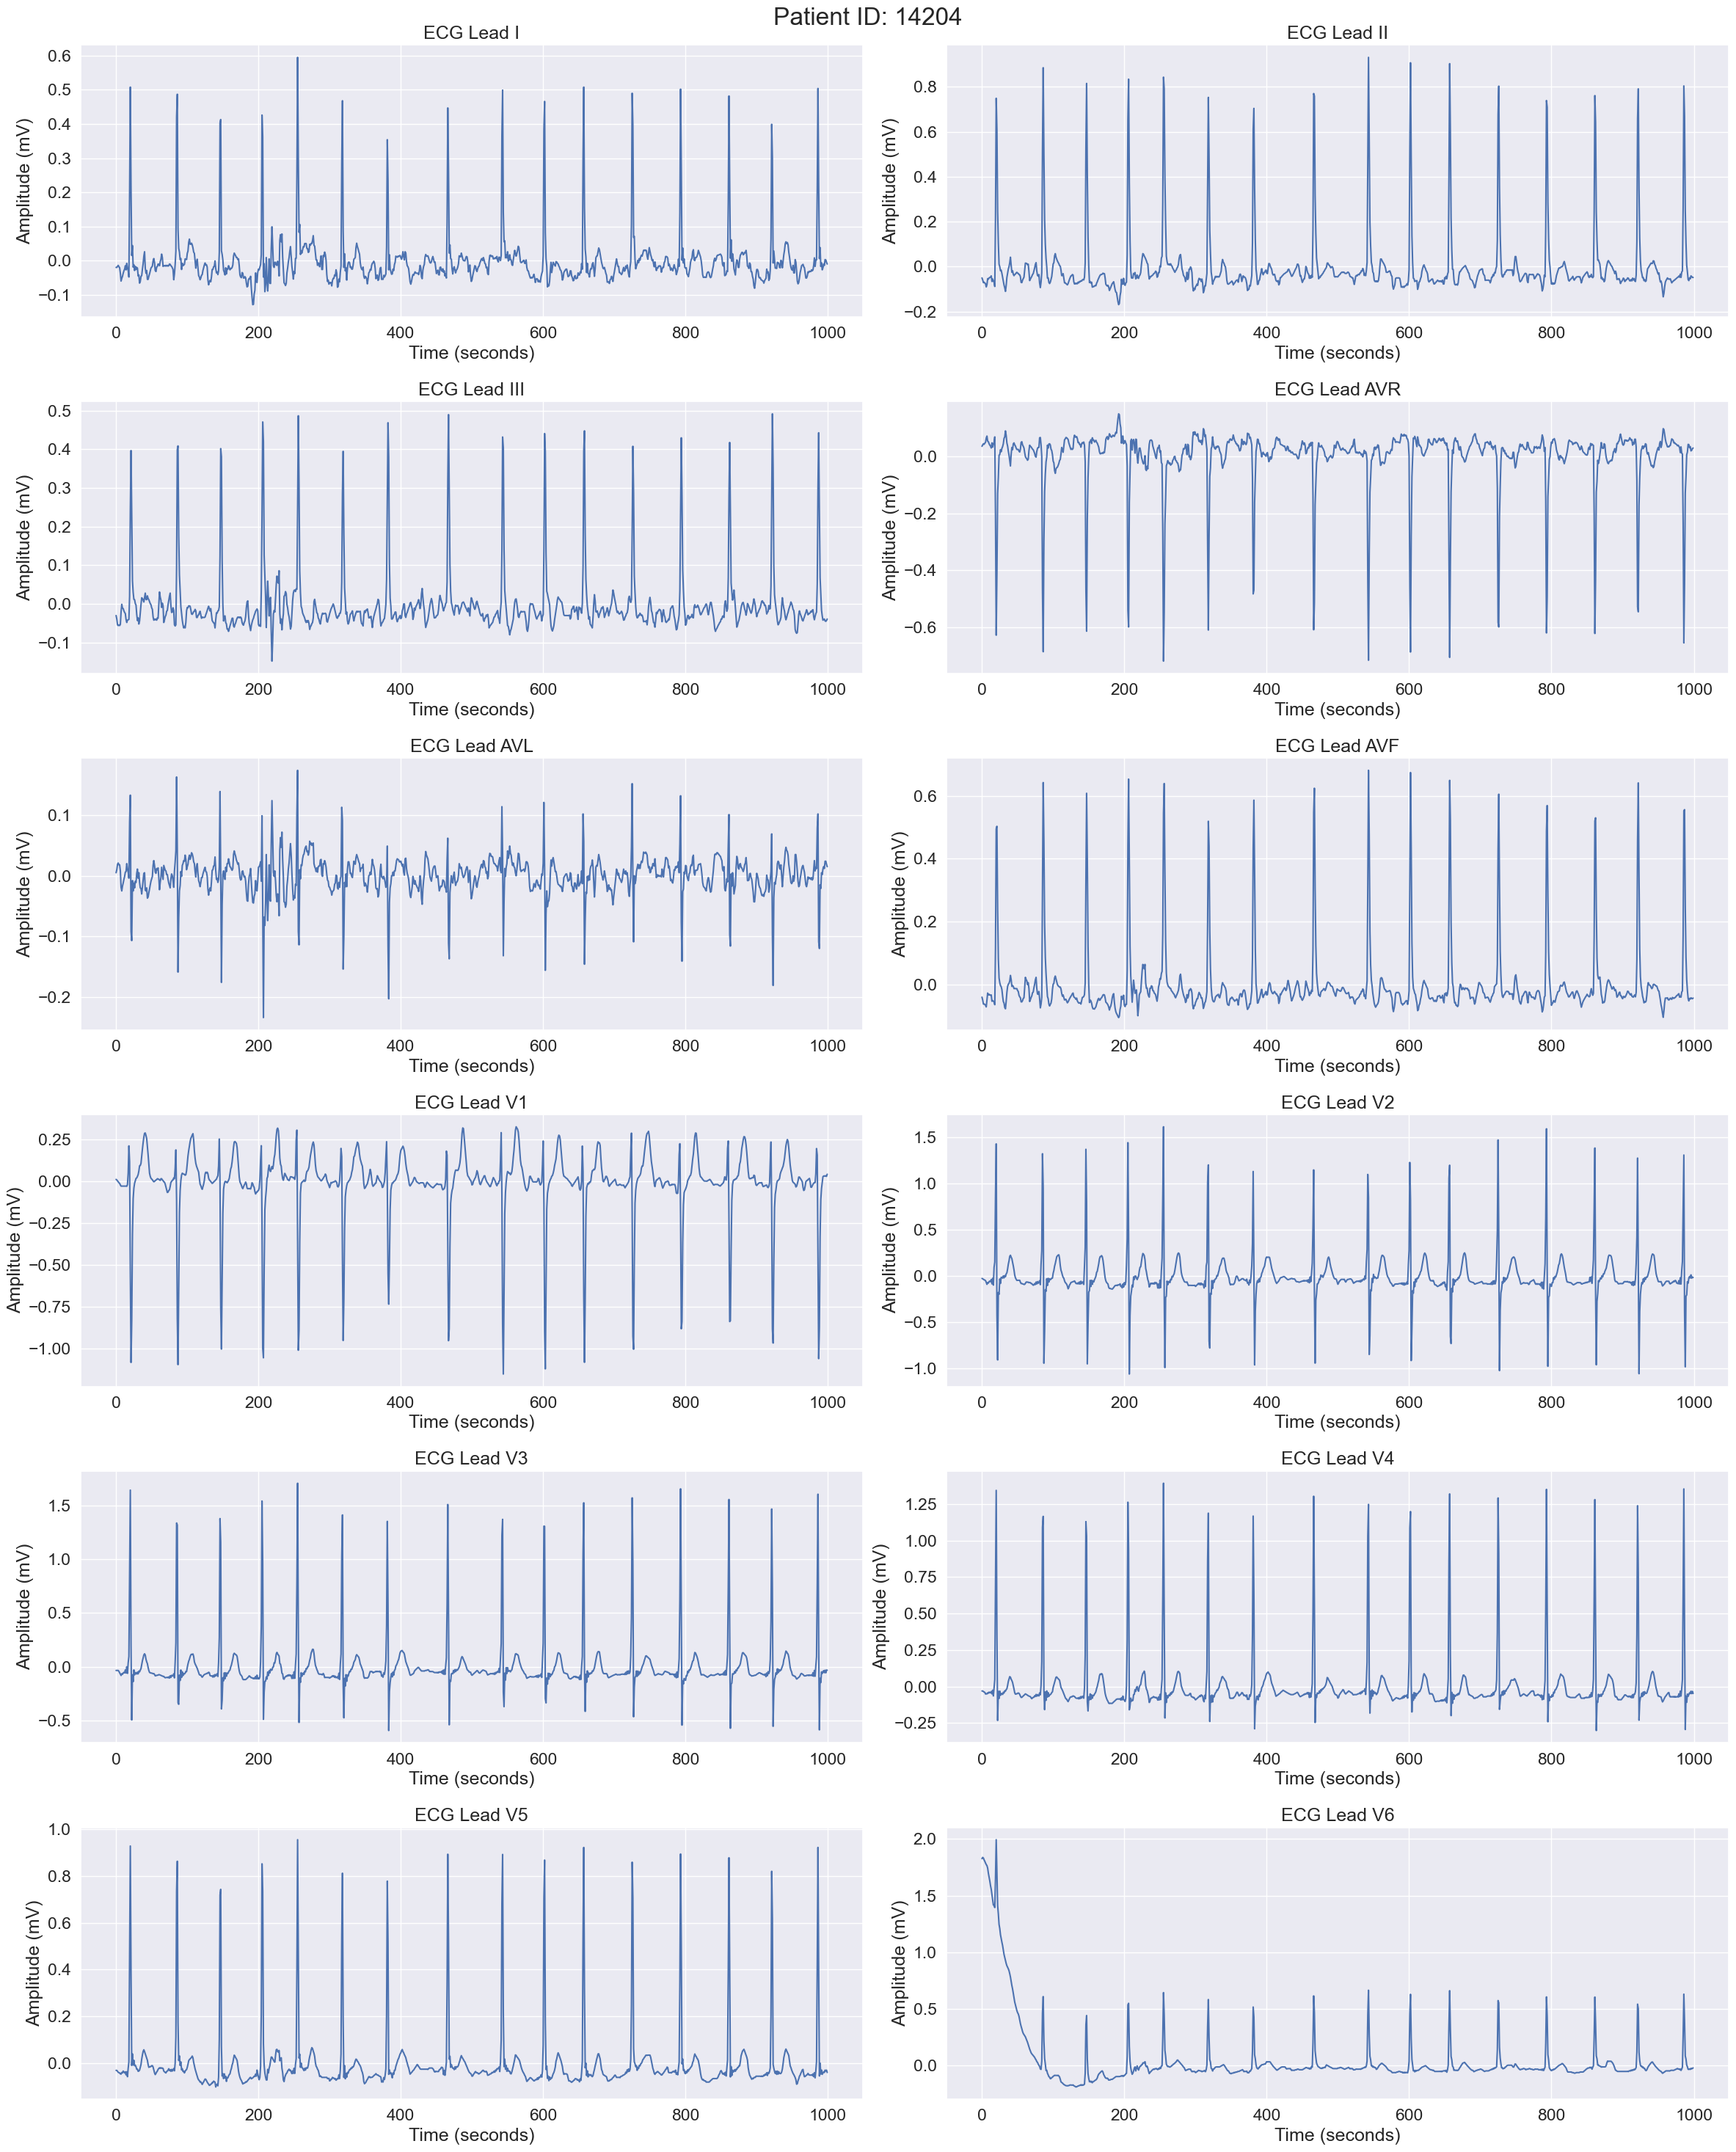

In [12]:
# Assuming 'raw_ecg' is your 3D ECG data and 'metadata_frame' has patient IDs
raw_ecg_index = np.random.randint(1,9517)

lead_labels = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']  # Your lead labels

plt.figure(figsize=(24, 30))  # Increase the figure size
sns.set(font_scale=1.5)  # Adjust the font scale for better readability

# Loop through each lead to create a 4x3 subplot layout
for lead in range(12):
    plt.subplot(6, 2, lead + 1)
    
    # Plotting the ECG data for each lead
    sns.lineplot(data=raw_ecg[raw_ecg_index, :, lead])
    
    # Adding axis labels and title for each lead
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude (mV)')
    plt.title(f'ECG Lead {lead_labels[lead]}')  # Set title according to lead_labels
    
    
# Add a main title for the entire figure
plt.suptitle(f'Patient ID: {int(metadata_frame.patient_id[raw_ecg_index])}', fontsize=24)

# Adjust layout to avoid overlap
plt.tight_layout(rect=[0, 0, 1, 1])  # Leave space for the title at the top
plt.show()


### Pre-processing of the ECG signal

To preprocess the ECG signal, I will apply two key steps: baseline removal and band-pass filtering. First, I will use a median filter to remove the baseline wander. This step ensures that the low-frequency drifts are eliminated while preserving the true signal shape. Afterward, I will apply a band-pass filer to isolate the frequency components of interest, which are between 0.5 Hz and 35 Hz. This helps to remove both high-frequency noise and low-frequency artifacts.

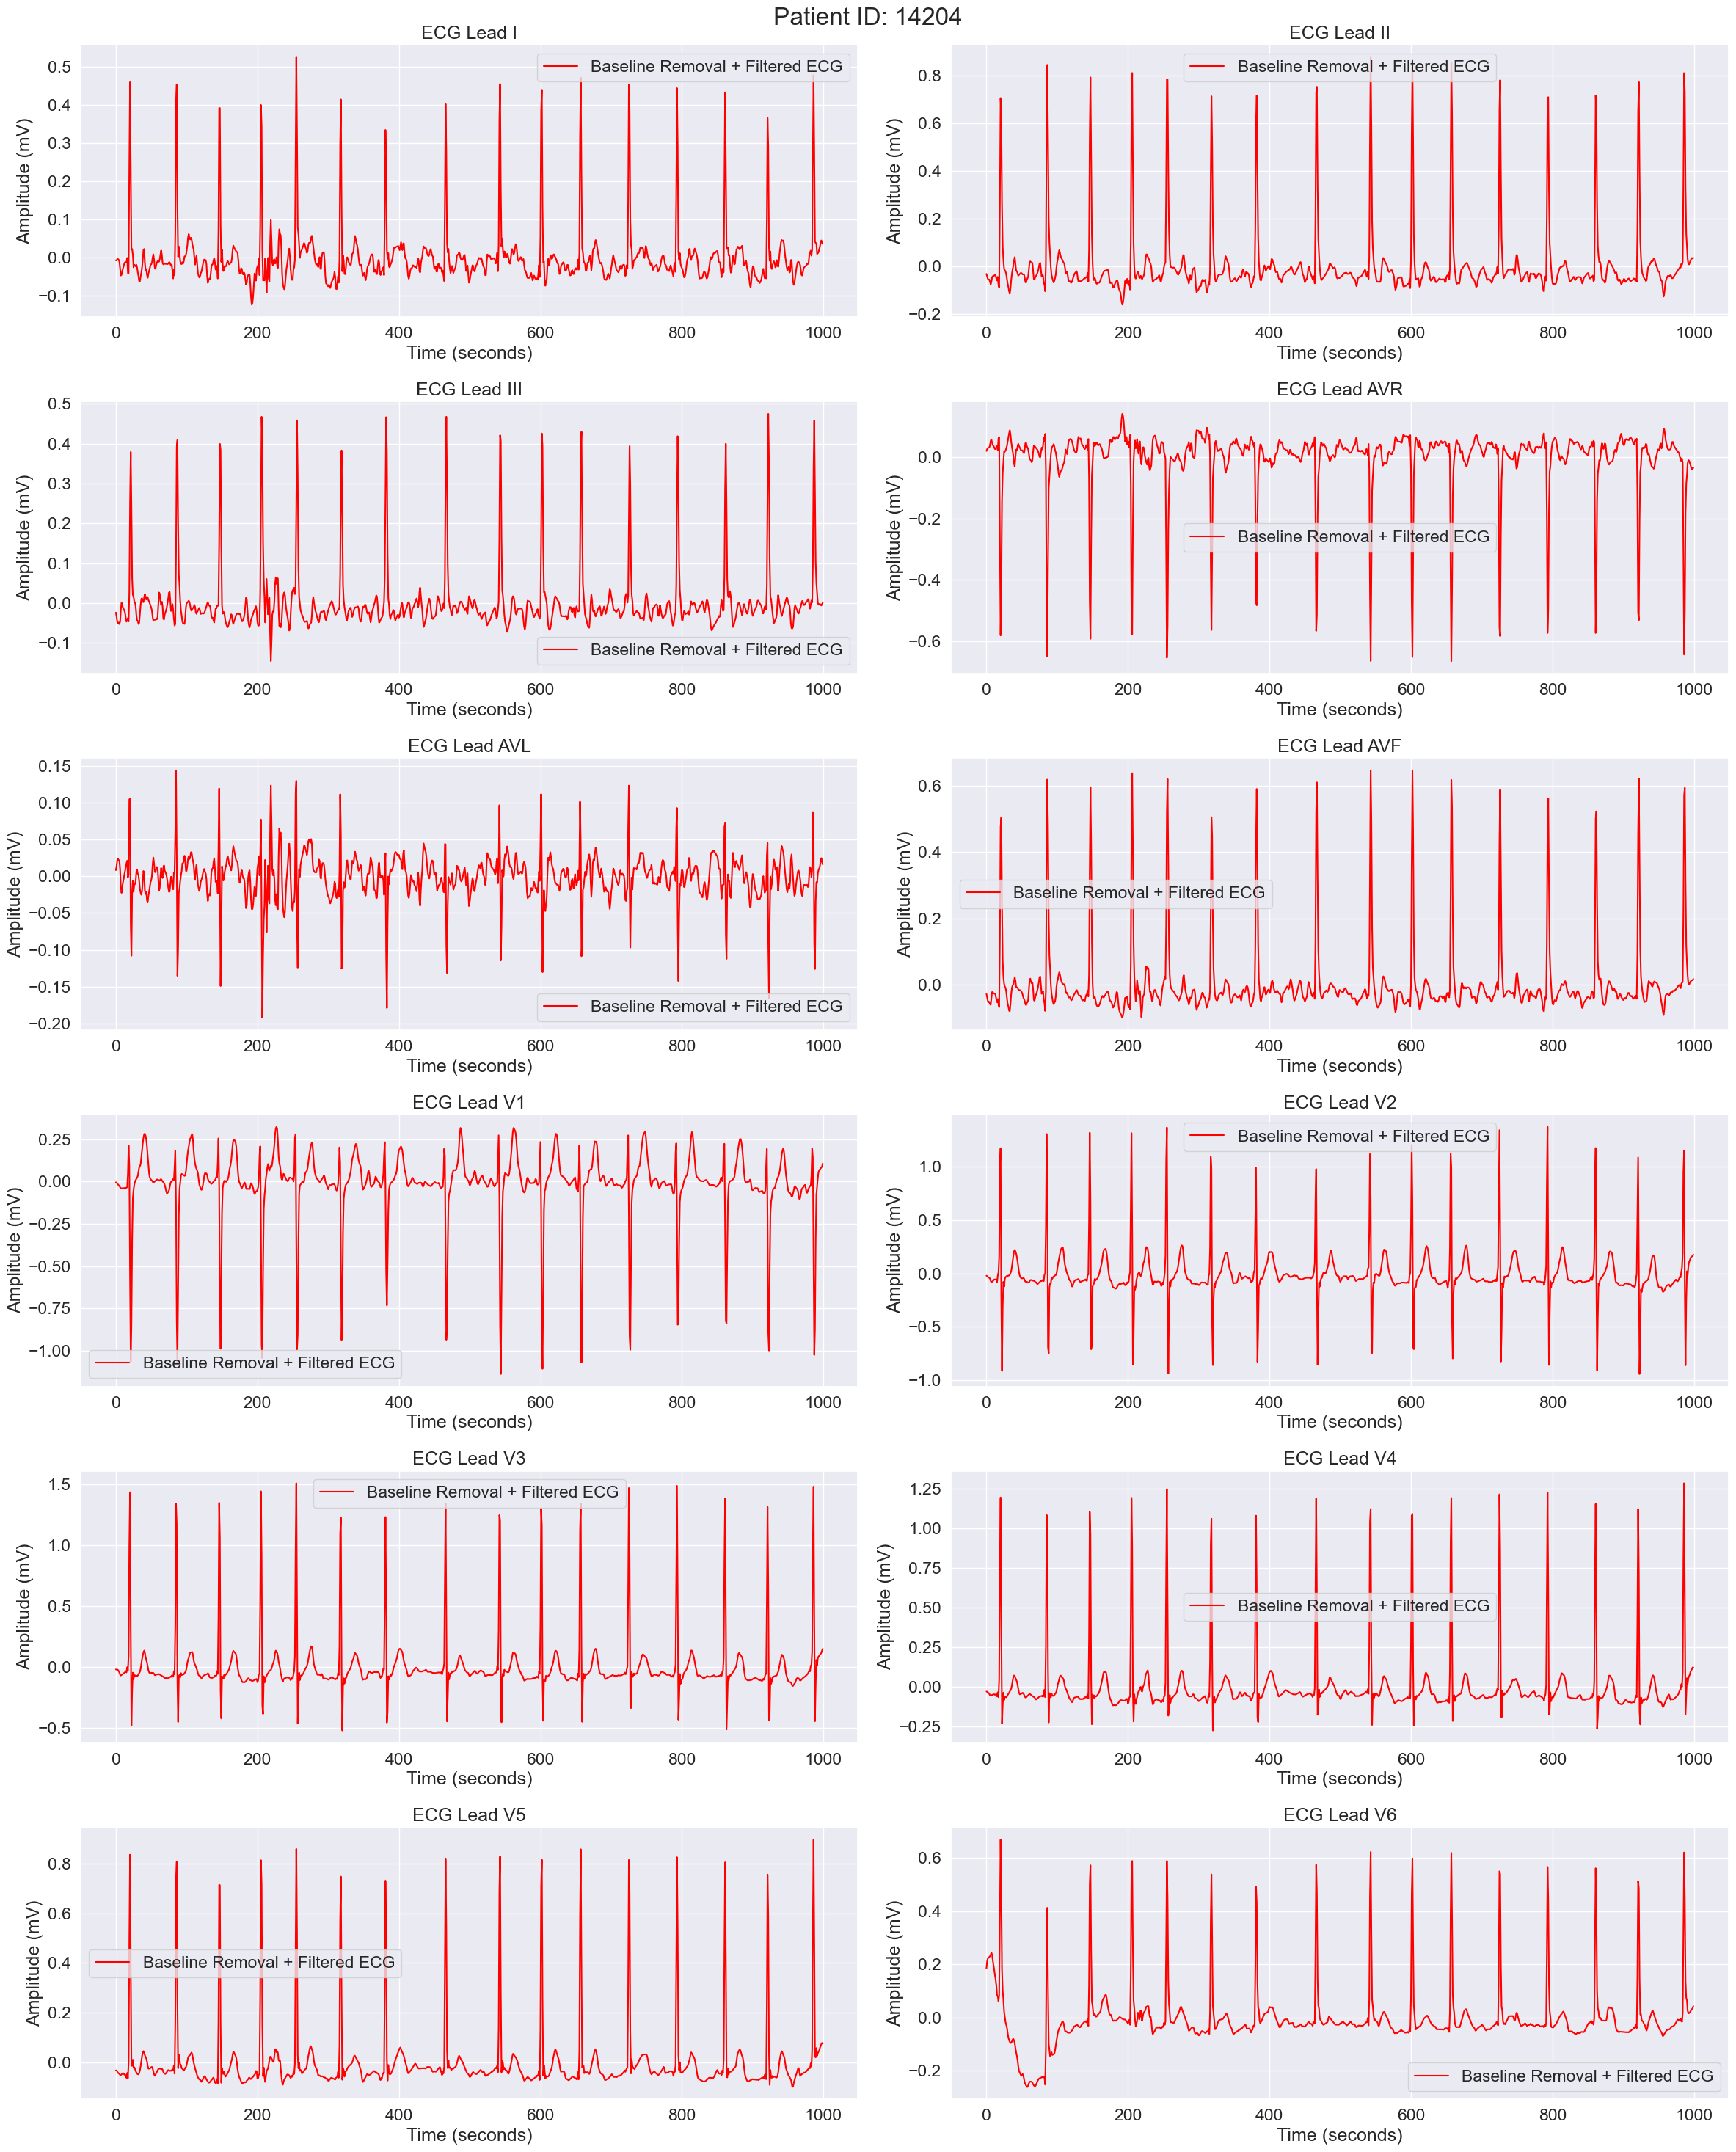

In [13]:
# Preprocessing of the signal 

# apply a filter to the signal 
from scipy.signal import butter, filtfilt
from scipy.signal import medfilt

# Function to create a band-pass filter
def bandpass_filter(data, lowcut, highcut, fs, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# Filter parameters
fs = 100  # Sampling frequency in Hz
highcut = 35  # Low-pass cutoff frequency in Hz
lowcut = 0.5  # High-pass cutoff frequency in Hz

plt.figure(figsize=(24, 30))  # Increase the figure size
sns.set(font_scale=1.5)  # Adjust the font scale for better readability

for lead in range(12):
    x = raw_ecg[raw_ecg_index,:,lead]

    # Median filter
    baseline = medfilt(x, kernel_size=201)  # Choose kernel_size based on signal length
    x_baseline_removal = x - baseline

    # Apply the band-pass filter
    filtered_ecg = bandpass_filter(x_baseline_removal, lowcut, highcut, fs)

    # Plot the original and processed ECG signals for each lead
    plt.subplot(6, 2, lead + 1)  
    sns.lineplot(data=filtered_ecg, color="red", label="Baseline Removal + Filtered ECG")
    
    # Set title and labels for each lead
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude (mV)')
    plt.title(f'ECG Lead {lead_labels[lead]}')
    
    # Add a legend only to the first subplot to avoid clutter
    if lead == 0:
        plt.legend(loc="upper right")

# Add a main title for the figure
plt.suptitle(f'Patient ID: {int(metadata_frame.patient_id[raw_ecg_index])}', fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 1])  # Adjust the space for the title
plt.show()


For further analysis, I work with one lead and one patient so it is computationally less expensive. I will focus on the Lead which provides better information about the cardiac activity in the patient. 

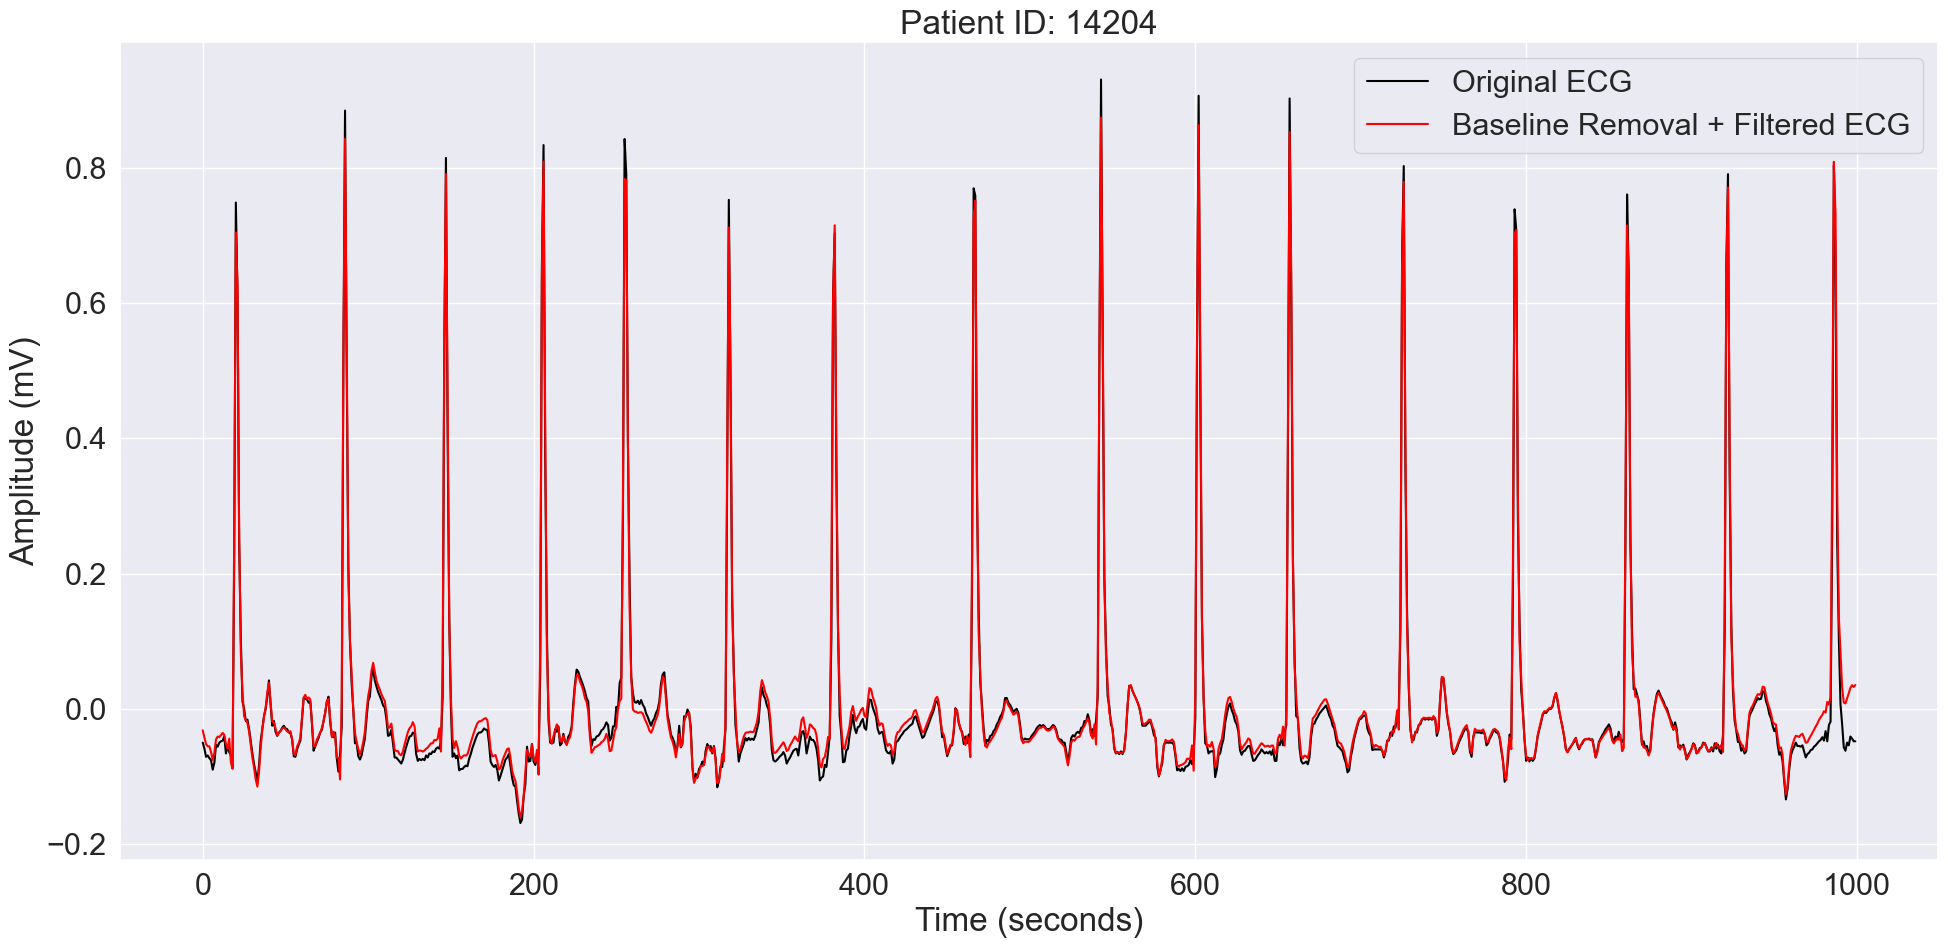

In [14]:
# Preprocessing of the signal 

# apply a filter to the signal 
from scipy.signal import butter, filtfilt
from scipy.signal import medfilt

# Filter parameters
fs = 100  # Sampling frequency in Hz
highcut = 35  # Low-pass cutoff frequency in Hz
lowcut = 0.5  # High-pass cutoff frequency in Hz

# one patiend with Lead --¿?
lead = 1 
x = raw_ecg[raw_ecg_index,:,lead]

# Median filter
baseline = medfilt(x, kernel_size=201)  # Choose kernel_size based on signal length
x_baseline_removal = x - baseline

# Apply the band-pass filter
filtered_ecg = bandpass_filter(x_baseline_removal, lowcut, highcut, fs)

# Plot
plt.figure(figsize=(20,10))
sns.set(font_scale=2)
sns.lineplot(data=x, color="black", label="Original ECG").set(xlabel='seconds', title=(f'ECG lead: {int(lead+1)}'))
sns.lineplot(data=filtered_ecg, color="red", label="Baseline Removal + Filtered ECG").set(xlabel='seconds', title=(f'ECG lead: {int(lead+1)}'))
plt.title(f'Patient ID: {int(metadata_frame.patient_id[raw_ecg_index])}')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (mV)')

plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

### Identify the heart beat of the signal, average and total heart beat in the signal

I will find the exact R-peaks locations which will allow to calculate intervals between beats. Thease are the R-R intervals which are used to compute the Heart Rate Variability. Firsly, I will use the find_peaks function from scipy.signal to obtain the R-peaks and then I will compute the R-R interval. 

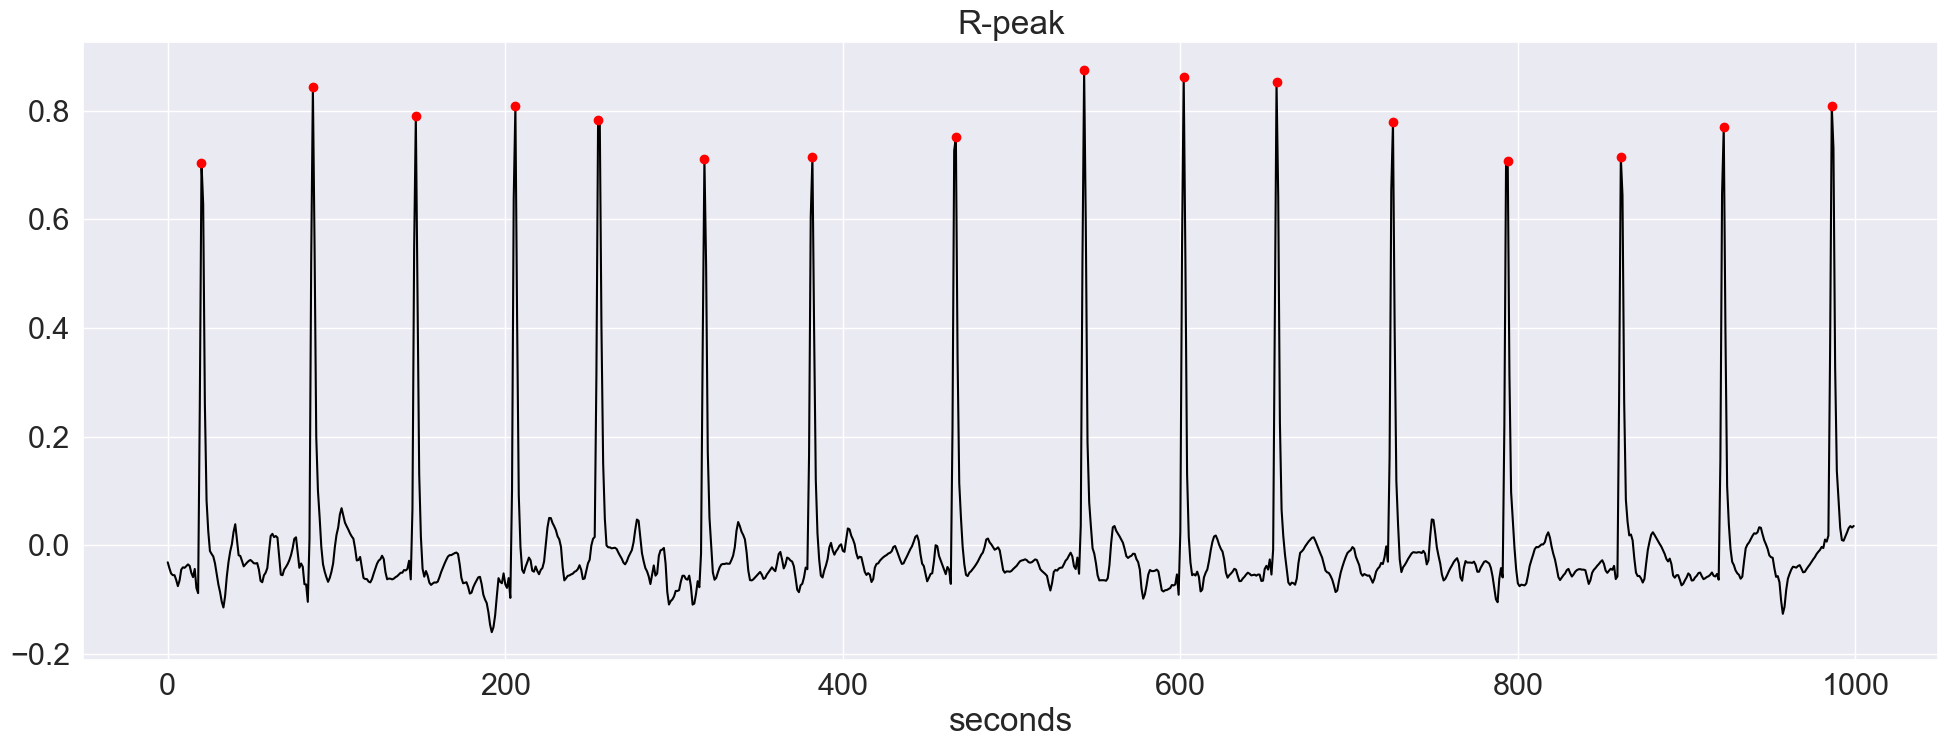

In [15]:
from scipy.signal import find_peaks

peaks, _ = find_peaks(filtered_ecg, height=0.25, distance=30)  # Adjust the height and distance based on your signal

plt.figure(figsize=(20,8))
sns.set(font_scale=2)
sns.lineplot(data=filtered_ecg, color='black').set(xlabel='seconds', title=('R-peak'))
plt.scatter(peaks, filtered_ecg[peaks], color='red', label='R-peaks', zorder=3)

plt.tight_layout()
plt.show()


### Average heart beat of the signal

In [16]:
def heartrate_ECG(time_pics_ECG, sampling_rate):
    
    heart_Ecg=[]

    for z in range(len(time_pics_ECG)):
        if z!=len(time_pics_ECG)-1 :
            rr_interval = (time_pics_ECG[z+1]-time_pics_ECG[z])/sampling_rate
            heart_Ecg.append(rr_interval)
    
    heart_rate_ECG = 60/np.mean(heart_Ecg) #heart rate 
    print("This is the average heart rate: ", round(heart_rate_ECG,2), "bpm")

    total_heart_rate = len(heart_Ecg) / (len(filtered_ecg) / sampling_rate) * 60  # in bpm
    print("This is the total heart rate: ", round(total_heart_rate,2), "bpm")

    return heart_rate_ECG, total_heart_rate

heart_rate_values = heartrate_ECG(peaks, sampling_rate)

This is the average heart rate:  93.17 bpm
This is the total heart rate:  90.0 bpm


### Identify the complex QRS in the signal and been able to annotate on it

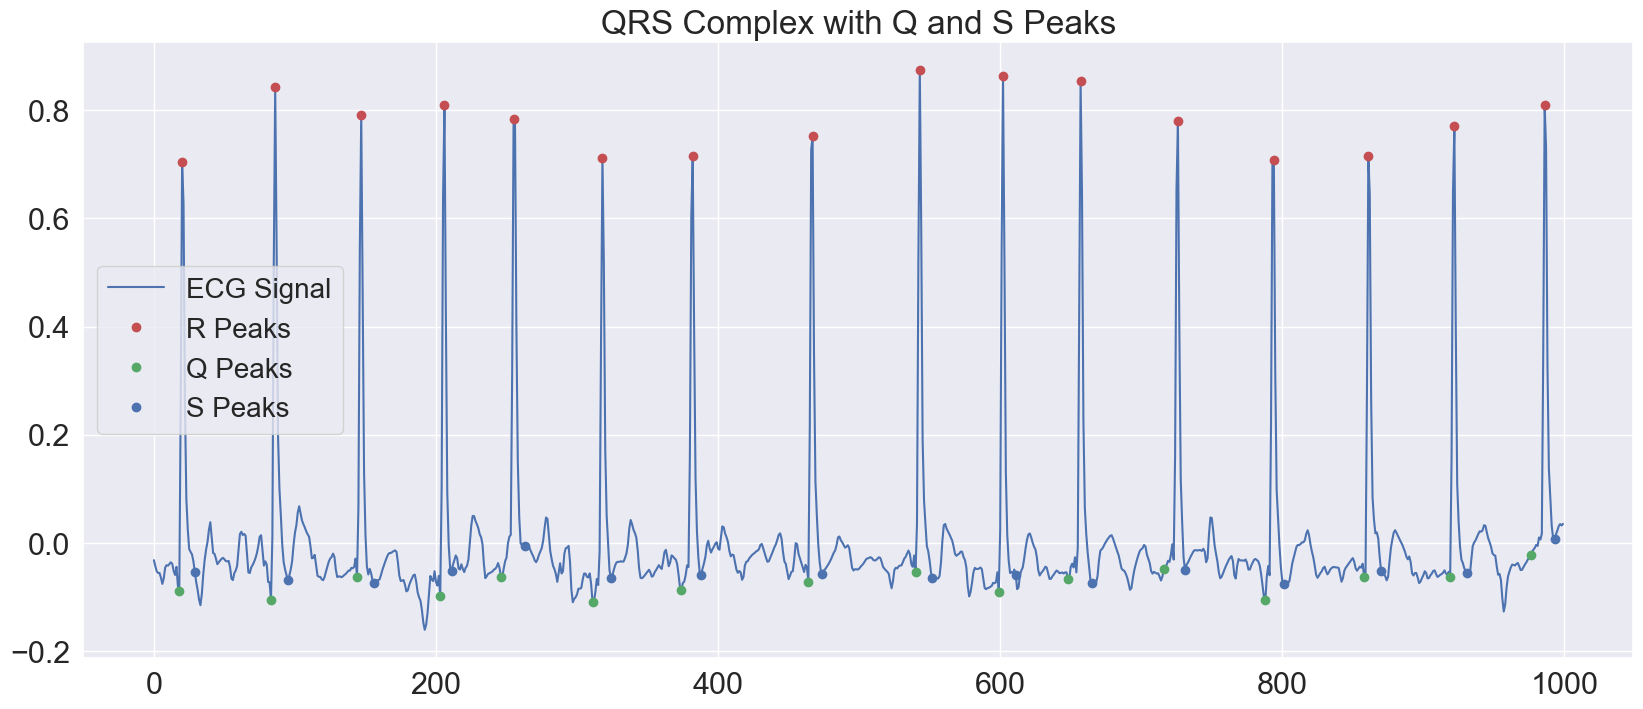

Number of R peaks detected: 16
Number of Q peaks detected: 16
Number of S peaks detected: 16


In [17]:
# Detect local minima (Q and S peaks) around each R peak

def find_local_min(signal, peak_indices, window_size=10):
    Q_peaks = []
    S_peaks = []
    
    for peak in peak_indices:
        # Find Q peak (local minimum before the R peak)
        if peak - window_size > 0:
            Q_window = signal[peak - window_size:peak]
            Q_local_min = np.argmin(Q_window) + (peak - window_size)
            Q_peaks.append(Q_local_min)
        
        # Find S peak (local minimum after the R peak)
        if peak + window_size < len(signal):
            S_window = signal[peak:peak + window_size]
            S_local_min = np.argmin(S_window) + peak
            S_peaks.append(S_local_min)
    
    return np.array(Q_peaks), np.array(S_peaks)

# Set the window size to find Q and S peaks around each R peak
window_size =10  # Adjust this based on your sampling rate
Q_peaks, S_peaks = find_local_min(filtered_ecg, peaks, window_size)

plt.figure(figsize=(20,8))
sns.set(font_scale=2)
plt.plot(filtered_ecg, label='ECG Signal')
plt.plot(peaks, filtered_ecg[peaks], "ro", label='R Peaks')  # R peaks
plt.plot(Q_peaks, filtered_ecg[Q_peaks], "go", label='Q Peaks')  # Q peaks (green)
plt.plot(S_peaks, filtered_ecg[S_peaks], "bo", label='S Peaks')  # S peaks (blue)
plt.title("QRS Complex with Q and S Peaks")
plt.legend(fontsize='small')
plt.show()

# Print number of detected Q, R, and S peaks
print(f"Number of R peaks detected: {len(peaks)}")
print(f"Number of Q peaks detected: {len(Q_peaks)}")
print(f"Number of S peaks detected: {len(S_peaks)}")